# MAXIS米株 S&P 500 (2558) ETF vs eMAXIS Slim 米国株式 (S&P 500) Mutual Fund

MUFG S&P500 ETF vs eMAXIS Slim S&P500 mutual fund: which has performed best?

Code to download price data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

def url_to_df(url):
    return pd.read_csv(url, encoding='cp932', skiprows = 2, parse_dates = [0], index_col = [0],
                      names=['date', 'price', 'price_div_reinv', 'div', 'assets'])

etf_url = 'https://maxis.mukam.jp/content/csv/fundCsv.php?fund_cd=182558' # link from https://maxis.mukam.jp/etf_fund/182558.html
mutual_url = 'https://emaxis.jp/content/csv/fundCsv.php?fund_cd=253266' # link from https://emaxis.jp/fund/253266.html

ind = 'S&P500'

etf = url_to_df(etf_url)
mutual = url_to_df(mutual_url)

start_date = etf.index.min()
mutual = mutual[mutual.index >= start_date] # match date range of mutual data to ETF data
mutual.to_csv('mutual_' + ind + '.csv', index=True)

# Benchmark and benchmark total returns indices for comparison
benchmark = yf.Ticker('^GSPC').history(start=str(etf.index.min()).split()[0])
benchmark_tr = yf.Ticker('^SP500TR').history(start=str(etf.index.min()).split()[0])

# Daily USDJPY FX rates used to rebased the USD-based index to JPY
usdjpy = yf.Ticker('JPY=X').history(start=str(start_date).split()[0])
usdjpy = usdjpy[usdjpy.index.isin(benchmark.index)] # cut down data to match dates in benchmark

# Create columns with the JPY-based benchmark indices
benchmark['Open_jpy'] = usdjpy['Open'] * benchmark['Open']
benchmark_tr['Open_jpy'] = usdjpy['Open'] * benchmark_tr['Open']
benchmark['Close_jpy'] = usdjpy['Close'] * benchmark['Close']
benchmark_tr['Close_jpy'] = usdjpy['Close'] * benchmark_tr['Close']

benchmark.to_csv('benchmark_' + ind + '.csv', index=True)
benchmark_tr.to_csv('benchmark_tr_' + ind + '.csv', index=True)

Create a dividends table for the ETF. Add dividend pay dates, foreign tax data, and calculate net dividends (net of foreign tax and domestic tax, with foreign tax credit claimed).

In [2]:
jp_income_tax_rate = 0.15315
jp_inhabitant_tax_rate = 0.05

dividends = etf[etf['div'].notna()]['div'].copy().to_frame()
dividends['pay_date'] = pd.to_datetime(['2020-07-17', '2021-01-15', '2021-07-16'])
# first dividend foreign tax rate source: https://starwaytohappylife.blog.fc2.com/blog-entry-1250.html
# second dividend foreign tax rate source: https://mrmarket-japan.com/tousihoka/etf-toushin-double-taxation/
# used reasonable approximation for third dividend tax rate
dividends['foreign_tax_rate'] = [0.0824283016, 0.1063057439, 0.1]
dividends['net_div'] = (dividends['div'] * (dividends['foreign_tax_rate']+1) * 
                        (1-jp_income_tax_rate-jp_inhabitant_tax_rate))
dividends.head()

,div,pay_date,foreign_tax_rate,net_div
date,,,,
2020-06-08,27.0,2020-07-17,0.082428,23.288391
2020-12-08,63.0,2021-01-15,0.106306,55.538263
2021-06-08,47.0,2021-07-16,0.100000,41.197145


Calculate growth of net dividends reinvested on pay date.

In [3]:
for i, (_, row) in enumerate(dividends.iterrows()):
    etf['div_'+str(i)] = 0.0
    div = row['net_div']
    pay_date = row['pay_date']
    buy_price =  etf.loc[pay_date, 'price'] 
    etf.loc[etf.index >= pay_date, 'div_'+str(i)] = div*etf.loc[etf.index >= pay_date, 'price']/buy_price

etf.to_csv('etf_' + ind + '.csv', index=True)

Create function to calculate the return of the ETF based on lump sum investment on chosen date, subsequently reinvesting the net dividends on pay date.

In [4]:
def etf_return(df, date):
    date = pd.to_datetime(date)
    investment = df['price'].copy()
    for i, index in enumerate(dividends.index):
        if date > index:
            continue
        investment += df['div_'+str(i)]
        
    return investment

Function to return a data series of prices normalized to a chosen date.

In [5]:
def normlize_to_date(series, date):
    return (series/series.loc[date]).copy()

Calculate the growths of the mutual and the ETF funds, and their difference, based on initial investment on date.

In [6]:
def grow(mutual, etf, date):
    date = pd.to_datetime(date)

    mutual_growth = normlize_to_date(mutual['price'], date)
    etf_growth = normlize_to_date(etf_return(etf, date), date)

    growth_difference = (mutual_growth - etf_growth)*100
    
    return mutual_growth, etf_growth, growth_difference

Plot the results and save the figure:

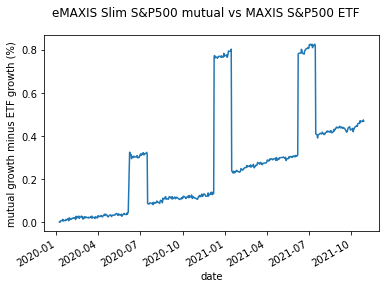

In [7]:
date = '2020-01-08'
mutual_growth, etf_growth, growth_difference = grow(mutual, etf, date)

ax = growth_difference.plot()
ax.set_ylabel('mutual growth minus ETF growth (%)')
fig = plt.gcf()
fig.suptitle('eMAXIS Slim ' + ind + ' mutual vs MAXIS ' + ind + ' ETF')
fig.savefig('slim_vs_2558_growth.png', dpi=100)

Plot the performance of the funds against the benchmark index:

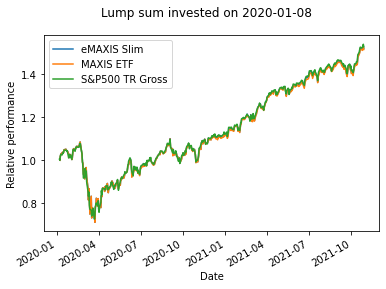

In [8]:
ax = mutual_growth.plot(label='eMAXIS Slim')
etf_growth.plot(ax=ax, label='MAXIS ETF')
normlize_to_date(benchmark_tr['Open_jpy'], date).plot(ax=ax, label=ind + ' TR Gross')
ax.legend()
ax.set_ylabel('Relative performance')
fig = plt.gcf()
fig.suptitle('Lump sum invested on ' + date)
fig.savefig('slim_vs_2558_benchmark.png', dpi=100)

Some checks of the annual growth figures for the year running from the end of September 2020 against numbers from last graph on https://shintaro-money.com/maxis-sp500-2558/:

In [9]:
start_date = '2020-09-30'
end_date = '2021-09-30'

# ETF paying Japan taxes on dividends (with foreign tax credit)
((etf.loc[end_date, 'price']
  +etf.loc[end_date, 'div_0']
  +etf.loc[end_date, 'div_1'])
 /etf.loc[start_date, 'price'])

1.3959149567621636

In [10]:
# ETF assuming no Japan taxes on dividends
etf.loc[end_date, 'price_div_reinv']/etf.loc[start_date, 'price_div_reinv']

1.3986966824644549

In [11]:
# Mutual fund
mutual.loc[end_date, 'price']/mutual.loc[start_date, 'price']

1.3994055972921655

In [12]:
# Benchmark total returns index (gross)
benchmark_tr.loc[end_date, 'Open_jpy']/benchmark_tr.loc[start_date, 'Open_jpy']

1.4063378561735982

The second and third numbers agree with the numbers from the final 騰落率 vs 実質コスト graph on the Shintaro website. The final number (S&P500 index growth) is a little off compared to Shintaro money, but still reasonable.

Conclusion: the ETF lagged the mutual by about 0.35% for the one year period from the end of September 2020, i.e. slightly more than the 0.07% reported on the Shintaro website. 